In [2]:
local = True

In [3]:
if not local:
    ! pip install sdv
    ! pip install gretel-synthetics

In [69]:
import sys

import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
import collections as coll
import tqdm
import math
#from synthetic_data_generation.generator import *
# Import libraries
from sdv.sequential.par import PARSynthesizer
from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata

import matplotlib.dates as md
import torch
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
import dtw

if local:
    sys.path.append('../../src/')
    from similarity_check.SimilarityCheck import *
    from privacy_check.privacy_check import PrivacyCheck


In [183]:
def get_energy_data_metadata(rows_limit = 1000, interpolate = True, drop_na_cols = True):
    datasets = load_csvs(folder_name='./data/') if local else load_csvs(folder_name='.')
    df = datasets["energy_dataset"].iloc[:rows_limit]
    if drop_na_cols:
        df = df.dropna(axis = 1, how = "all")
    if interpolate:
        df = df.interpolate()
    
    # Switch the shape of the dataframe to long format
    gen_columns = list(filter(lambda x: "generation" in x, df.columns))
    df_long = df.melt(["time"], gen_columns)
    df_long.columns = ["time","energy_source", "value"]

    # Clean time and energy_source column
    df_long["time"] = pd.to_datetime(df_long["time"], utc = True).dt.tz_localize(None)
    df_long["energy_source"] = df_long["energy_source"].apply(lambda x: x.replace("generation ", ""))
    
    # Add a context column: used as input feature to the model as characteristic of the time series
    # to get a right sense of the units, we pass the mean, but this is an arbitrary choice.
    for src in df_long.energy_source.unique():
        subset = df_long[df_long['energy_source'] == src]
        df_long.loc[subset.index,'mean'] = np.mean(subset['value']) 
        #df_long.loc[subset.index,'std'] = np.std(subset['value']) 

    # Metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df_long)

    metadata.update_column(
        "energy_source",
        sdtype='id',
    )
    metadata.set_sequence_key("energy_source")
    metadata.update_column(
        column_name='time',
        sdtype='datetime',
        datetime_format='%Y-%m-%d %H:%M:%S')
    metadata.set_sequence_index(column_name='time')


    return df_long, metadata

def plot_original_synthetic_ts(df_original, df_synth, count_real = 5, count_synth = 1):
    # Plot original data vs. synthetic data
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    by_source = df_original.groupby('energy_source')
    MAX_COUNT = [count_real, count_synth]
    c = 0

    for i, df in enumerate([df_original, df_synth]):
        by_source = df.groupby('energy_source')
        c = 0
        for name, group in by_source:
            if i == 1:
                name = None
            if c == MAX_COUNT[i]:
                break
            c += 1
            axs[i].plot(group['time'], group['value'], label=name)
        if i == 0:
            axs[i].legend()
        axs[i].set_xlabel("Date")
        axs[i].set_ylabel("Energy generation")

    axs[0].set_title("Original data")
    axs[1].set_title("Synthetic data")
    plt.show()

def compute_dtw_matrix(df_original, df_synth, metadata):
    """
    Function that computes the DTW for every combination of original & synthetic sequences.

    :param df_original: original dataframe in long format
    :param df_synth: synthetic dataframe generated with PAR
    :param metadata: metadata of original dataframe

    -----------

    Returns: DataFrame with distance matrix
    """
    meta_dict = metadata.to_dict()
    sequence_key, sequence_index = meta_dict["sequence_key"], meta_dict["sequence_index"]
    ts_col = list(filter(lambda x: x not in [sequence_key, sequence_index], df_synth.columns))[0]
    sequence_key_values_synth = df_synth[sequence_key].unique()
    sequence_key_values_original = df_original[sequence_key].unique()

    dist_matrix = pd.DataFrame(np.zeros((len(sequence_key_values_synth), len(sequence_key_values_original))), columns=sequence_key_values_original,
                               index=sequence_key_values_synth)


    for i, row in enumerate(dist_matrix.iterrows()):
        synth_key, row = row
        ts_synth = df_synth[df_synth[sequence_key] == synth_key][ts_col].dropna().values
        if len(ts_synth) == 0:
            dist_matrix.iloc[i, :] = np.full(len(sequence_key_values_original),np.nan)
            continue
        for j, original_key in enumerate(sequence_key_values_original):
            ts_original = df_original[df_original[sequence_key] == original_key][ts_col].dropna().values
            if len(ts_original) == 0:
                dist_matrix.iloc[i, j] = np.nan
                continue
            alignment = dtw.dtw(ts_synth, ts_original)
            dist = alignment.normalizedDistance
            dist_matrix.iloc[i, j] = dist


    return dist_matrix

# Possible methods
For the generation of synthetic datasets with time series data, we have several methods at our disposal:
- PARSynthesizer (```sdv```): Probabilistic AutoRegressive model that allows learning multi-type, multivariate timeseries data and later on generate new synthetic data that has the same format and properties as the learned one.
https://arxiv.org/pdf/2207.14406.pdf
- DoppelGANger (```gretel-synthetics```): DoppelGANger is based on a generative adversarial network (GAN) with some modifications to better fit the time series generation task.
- TimeGAN (```ydata-synthetic```): GAN based adapted to time series using a new concept: supervised loss. https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf

## PARSynthesizer

#### With NA values in the original dataset

In [17]:
df_long, metadata = get_energy_data_metadata(interpolate=False, drop_na_cols=False)

2023-05-24 12:36:04,309 : MainThread : INFO : Detected metadata:
2023-05-24 12:36:04,309 : MainThread : INFO : {
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        },
        "Context": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


In [18]:
df_long

time energy_source   value      Context
0     2014-12-31 23:00:00       biomass   447.0   483.091001
1     2015-01-01 00:00:00       biomass   449.0   483.091001
2     2015-01-01 01:00:00       biomass   448.0   483.091001
3     2015-01-01 02:00:00       biomass   438.0   483.091001
4     2015-01-01 03:00:00       biomass   428.0   483.091001
...                   ...           ...     ...          ...
20995 2015-02-11 10:00:00  wind onshore  9396.0  6969.915066
20996 2015-02-11 11:00:00  wind onshore  8364.0  6969.915066
20997 2015-02-11 12:00:00  wind onshore  7684.0  6969.915066
20998 2015-02-11 13:00:00  wind onshore  6762.0  6969.915066
20999 2015-02-11 14:00:00  wind onshore  6798.0  6969.915066

[21000 rows x 4 columns]

In [14]:
# Analyzing NA values
epochs_list = [5, 10, 50, 100, 200]
na_values = []
for epochs in epochs_list:
    # Step 1: Create the synthesizer
    synthesizer = PARSynthesizer(metadata, verbose = True, epochs = epochs, cuda = True, context = ['mean'])
    # Step 2: Train the synthesizer
    synthesizer.fit(df_long)
    # Step 3: Generate synthetic data.
    synthetic_data = synthesizer.sample(num_sequences=1)
    na_count = synthetic_data.isna().sum()["value"]
    na_values.append(na_count)

2023-05-17 15:56:51,213 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,215 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,216 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,217 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-17 15:56:51,304 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,305 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,306 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,306 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-17 15:56:51,314 : MainThread : INFO : Fitting table None metadata
2023-05-17 15:56:51,315 : MainThread : INFO : Fitting formatters for table None
2023-05-17 15:56:51,315 : MainThread : INFO : Fitting constraints for table None
2023-05-17 15:56:51,315 : MainThread : INFO : Setting the configuration for the ``HyperTransf

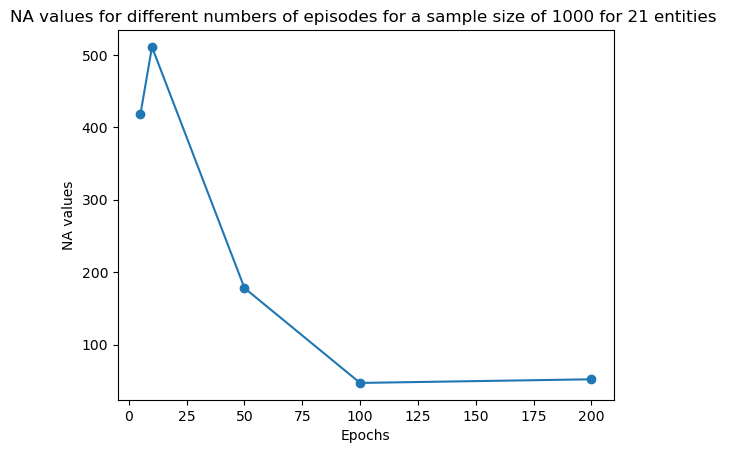

In [15]:
# Plot NA values
plt.plot(epochs_list, na_values, marker = "o")
plt.title("NA values for different numbers of episodes for a sample size of 1000 for 21 entities ")
plt.xlabel("Epochs")
plt.ylabel("NA values")
plt.show()

In [19]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 50, cuda = False, context_columns=['mean'])

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

2023-05-24 12:36:12,566 : MainThread : INFO : Fitting table None metadata
2023-05-24 12:36:12,572 : MainThread : INFO : Fitting formatters for table None
2023-05-24 12:36:12,574 : MainThread : INFO : Fitting constraints for table None
2023-05-24 12:36:12,575 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-24 12:36:12,630 : MainThread : INFO : Fitting table None metadata
2023-05-24 12:36:12,631 : MainThread : INFO : Fitting formatters for table None
2023-05-24 12:36:12,633 : MainThread : INFO : Fitting constraints for table None
2023-05-24 12:36:12,634 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-24 12:36:12,656 : MainThread : INFO : Fitting table None metadata
2023-05-24 12:36:12,657 : MainThread : INFO : Fitting formatters for table None
2023-05-24 12:36:12,657 : MainThread : INFO : Fitting constraints for table None
2023-05-24 12:36:12,658 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [20]:
synthetic_data_plot = synthesizer.sample(5)

100%|██████████| 5/5 [00:55<00:00, 11.05s/it]


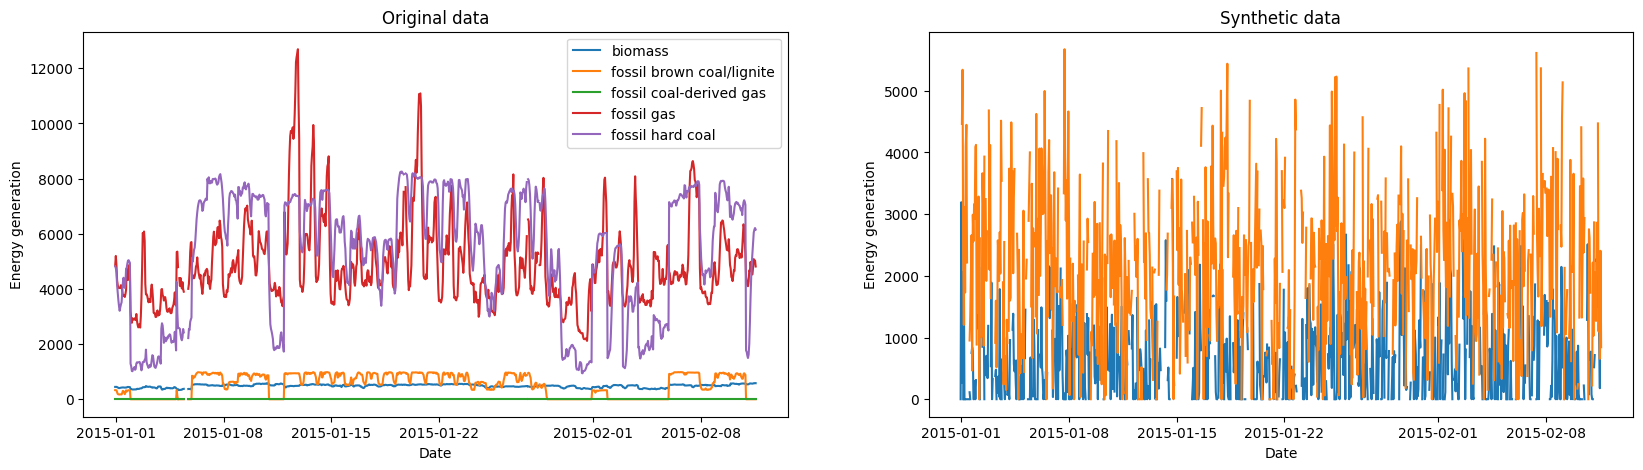

In [22]:
plot_original_synthetic_ts(df_long, synthetic_data_plot, 5, 2)

#### Interpolating NA values so there are none in the original dataset

In [184]:
df_long, metadata = get_energy_data_metadata()

2023-05-24 17:01:04,156 : MainThread : INFO : Detected metadata:
2023-05-24 17:01:04,157 : MainThread : INFO : {
    "columns": {
        "time": {
            "sdtype": "datetime"
        },
        "energy_source": {
            "sdtype": "categorical"
        },
        "value": {
            "sdtype": "numerical"
        },
        "mean": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


In [185]:
# adding std as another context column to give a pointer to the amount of variation did not help, so I removed it again
df_long

time energy_source   value       mean
0     2014-12-31 23:00:00       biomass   447.0   482.3770
1     2015-01-01 00:00:00       biomass   449.0   482.3770
2     2015-01-01 01:00:00       biomass   448.0   482.3770
3     2015-01-01 02:00:00       biomass   438.0   482.3770
4     2015-01-01 03:00:00       biomass   428.0   482.3770
...                   ...           ...     ...        ...
19995 2015-02-11 10:00:00  wind onshore  9396.0  6981.2475
19996 2015-02-11 11:00:00  wind onshore  8364.0  6981.2475
19997 2015-02-11 12:00:00  wind onshore  7684.0  6981.2475
19998 2015-02-11 13:00:00  wind onshore  6762.0  6981.2475
19999 2015-02-11 14:00:00  wind onshore  6798.0  6981.2475

[20000 rows x 4 columns]

In [147]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 128, cuda = False, context_columns=['mean'])

# Step 2: Train the synthesizer
synthesizer.fit(df_long)

2023-05-24 16:37:18,130 : MainThread : INFO : Fitting table None metadata
2023-05-24 16:37:18,135 : MainThread : INFO : Fitting formatters for table None
2023-05-24 16:37:18,138 : MainThread : INFO : Fitting constraints for table None
2023-05-24 16:37:18,139 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-24 16:37:18,205 : MainThread : INFO : Fitting table None metadata
2023-05-24 16:37:18,206 : MainThread : INFO : Fitting formatters for table None
2023-05-24 16:37:18,208 : MainThread : INFO : Fitting constraints for table None
2023-05-24 16:37:18,208 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-24 16:37:18,222 : MainThread : INFO : Fitting table None metadata
2023-05-24 16:37:18,222 : MainThread : INFO : Fitting formatters for table None
2023-05-24 16:37:18,223 : MainThread : INFO : Fitting constraints for table None
2023-05-24 16:37:18,223 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [44]:
synthesizer.save("models/energy1000_300ep_lin_int.pkl")

In [45]:
# Load synthesizer that you want
synthesizer = PARSynthesizer.load("models/energy1000_300ep_lin_int.pkl")

In [148]:
# Sample from it
synth_data = synthesizer.sample(20)

100%|██████████| 20/20 [04:07<00:00, 12.36s/it]


In [26]:
#synth_data.to_csv("synthetic_data/energy1000_20samples.csv")

# Compute DTW between synthetic and original

In [149]:
dist_matrix = compute_dtw_matrix(df_long, synth_data, metadata)

In [150]:
dist_matrix

biomass  fossil brown coal/lignite  fossil coal-derived gas   
00000  2580.811840                2359.122612              3077.602208  \
00001  1478.068852                1271.333453              1990.682650   
0000a  2322.829093                2125.211588              2834.678347   
0000b   139.499714                 142.644281               250.394615   
0000c   135.022533                 139.054965               137.280885   
0000d   296.506913                 215.463327               553.388967   
0000e  2047.048889                1924.452962              2327.094102   
0000f   145.090272                 136.985789               135.575453   
0000g  1478.082865                1336.655986              2009.792305   
0000h   215.167780                 157.122719               448.360227   
0000i   135.087177                 139.613882               152.327966   
0000j   149.601324                 135.208001               113.230382   
0000k  2874.980476                2754.383702              2914.133304   
0000l   143.222830                 131.731562               122.149812   
0000m   154.004042                 147.144650               305.978779   
0000n   143.339333                 134.082871               114.897931   
0000o  2321.506004                2237.321455              2808.777348   
0000p  2716.021217                2592.468453              3240.687153   
0000q   139.730751                 133.680915               135.787721   
0000r  2913.733659                2707.724046              3439.929678   

        fossil gas  fossil hard coal   fossil oil  fossil oil shale   
00000   624.594504        657.570808  2742.645228       3077.602208  \
00001   642.708309        767.663375  1646.999850       1990.682650   
0000a   546.981142        614.386534  2493.865089       2834.678347   
0000b  2512.109842       2128.787432   147.382761        250.394615   
0000c  2641.904892       2277.341478   114.419542        137.280885   
0000d  1842.686784       1660.736671   375.819832        553.388967   
0000e   551.651485        616.833216  2108.473133       2327.094102   
0000f  2639.104369       2284.495495   119.165216        135.575453   
0000g   565.251297        638.987601  1649.645362       2009.792305   
0000h  2016.323027       1830.721991   274.324234        448.360227   
0000i  2479.644365       2167.699783   118.160225        152.327966   
0000j  2354.363579       2093.598330   115.286894        113.230382   
0000k   842.253101        856.869673  2887.855262       2914.133304   
0000l  2713.714451       2311.186782   115.667989        122.149812   
0000m  2432.825865       2109.544999   175.457560        305.978779   
0000n  2606.391709       2263.669441   111.157453        114.897931   
0000o   616.319731        669.649065  2489.949460       2808.777348   
0000p   769.279380        768.153512  2898.169321       3240.687153   
0000q  2458.064051       2151.777615   117.538080        135.787721   
0000r   662.114153        704.506859  3078.762389       3439.929678   

       fossil peat   geothermal  hydro pumped storage consumption   
00000  3077.602208  3077.602208                       1490.381536  \
00001  1990.682650  1990.682650                        741.011473   
0000a  2834.678347  2834.678347                       1251.089630   
0000b   250.394615   250.394615                        221.294582   
0000c   137.280885   137.280885                        207.322956   
0000d   553.388967   553.388967                        262.376681   
0000e  2327.094102  2327.094102                       1120.146275   
0000f   135.575453   135.575453                        200.238028   
0000g  2009.792305  2009.792305                        760.020314   
0000h   448.360227   448.360227                        247.279404   
0000i   152.327966   152.327966                        204.633837   
0000j   113.230382   113.230382                        193.038334   
0000k  2914.133304  2914.133304                       1777.786108  

128 epochs and 50 samples

In [162]:
def plot_nearest_neighbors(dist_matrix, df, synth_data):
    '''
    Args:
        dist_matrix: the distance matrix storing distances between all time series and synthetic samples
        df: original dataframe in long format
        synth_data: the synthetically generated time series
    '''
    nearest_synth_ts = dist_matrix.idxmin(axis=0)
    # Init plotting
    n_plots = len(df["energy_source"].unique())
    fig, axs = plt.subplots(nrows=math.ceil(n_plots/2), ncols=2, figsize=(20,min(n_plots*2,30))) # TODO: account for odd number of plots by setting the last plot to ax.axis("off")
    if n_plots%2 !=0:
        axs[-1,-1].axis('off')
    axs = axs.reshape(-1)

    for i, (real_col, synth_name) in enumerate(nearest_synth_ts.items()):
        # Subset real dataset and extract y, x for plotting
        real_df_subset = df[df["energy_source"] == real_col]
        y_real = real_df_subset["value"]
        x_real = real_df_subset["time"]

        # Subset synthetic dataset and extract y, x for plotting
        synth_df_subset = synth_data[synth_data["energy_source"] == synth_name]
        y_synth = synth_df_subset["value"]
        x_synth = synth_df_subset["time"]
        axs[i].plot(x_real, y_real, label = f"Real ({real_col})")
        axs[i].plot(x_synth, y_synth, label = f"Synthetic ({synth_name})")
        axs[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        axs[i].set_title(f"Nearest neighbour: {real_col} (DTW-distance: {dist_matrix[real_col][synth_name]: .2f})")
        axs[i].legend()
    plt.show()

#### Comment: 

   * From these plots, we see that there are some rather unsatisfactory results. Often, the 'mean' order of magnitude is well preserved, but the deviations are usually not. This is especially visible for two kinds of time series: the ones with seemingly periodic changes, and those that change very little. 
   * One idea could be to train a separate model on a group of periodic time series, and on a group of fairly constant time series. The hope is that this will change the results. 
   * The second group of plots shows that running the model for an increased number of epochs (1000 instead of 128) does not seem to help. 

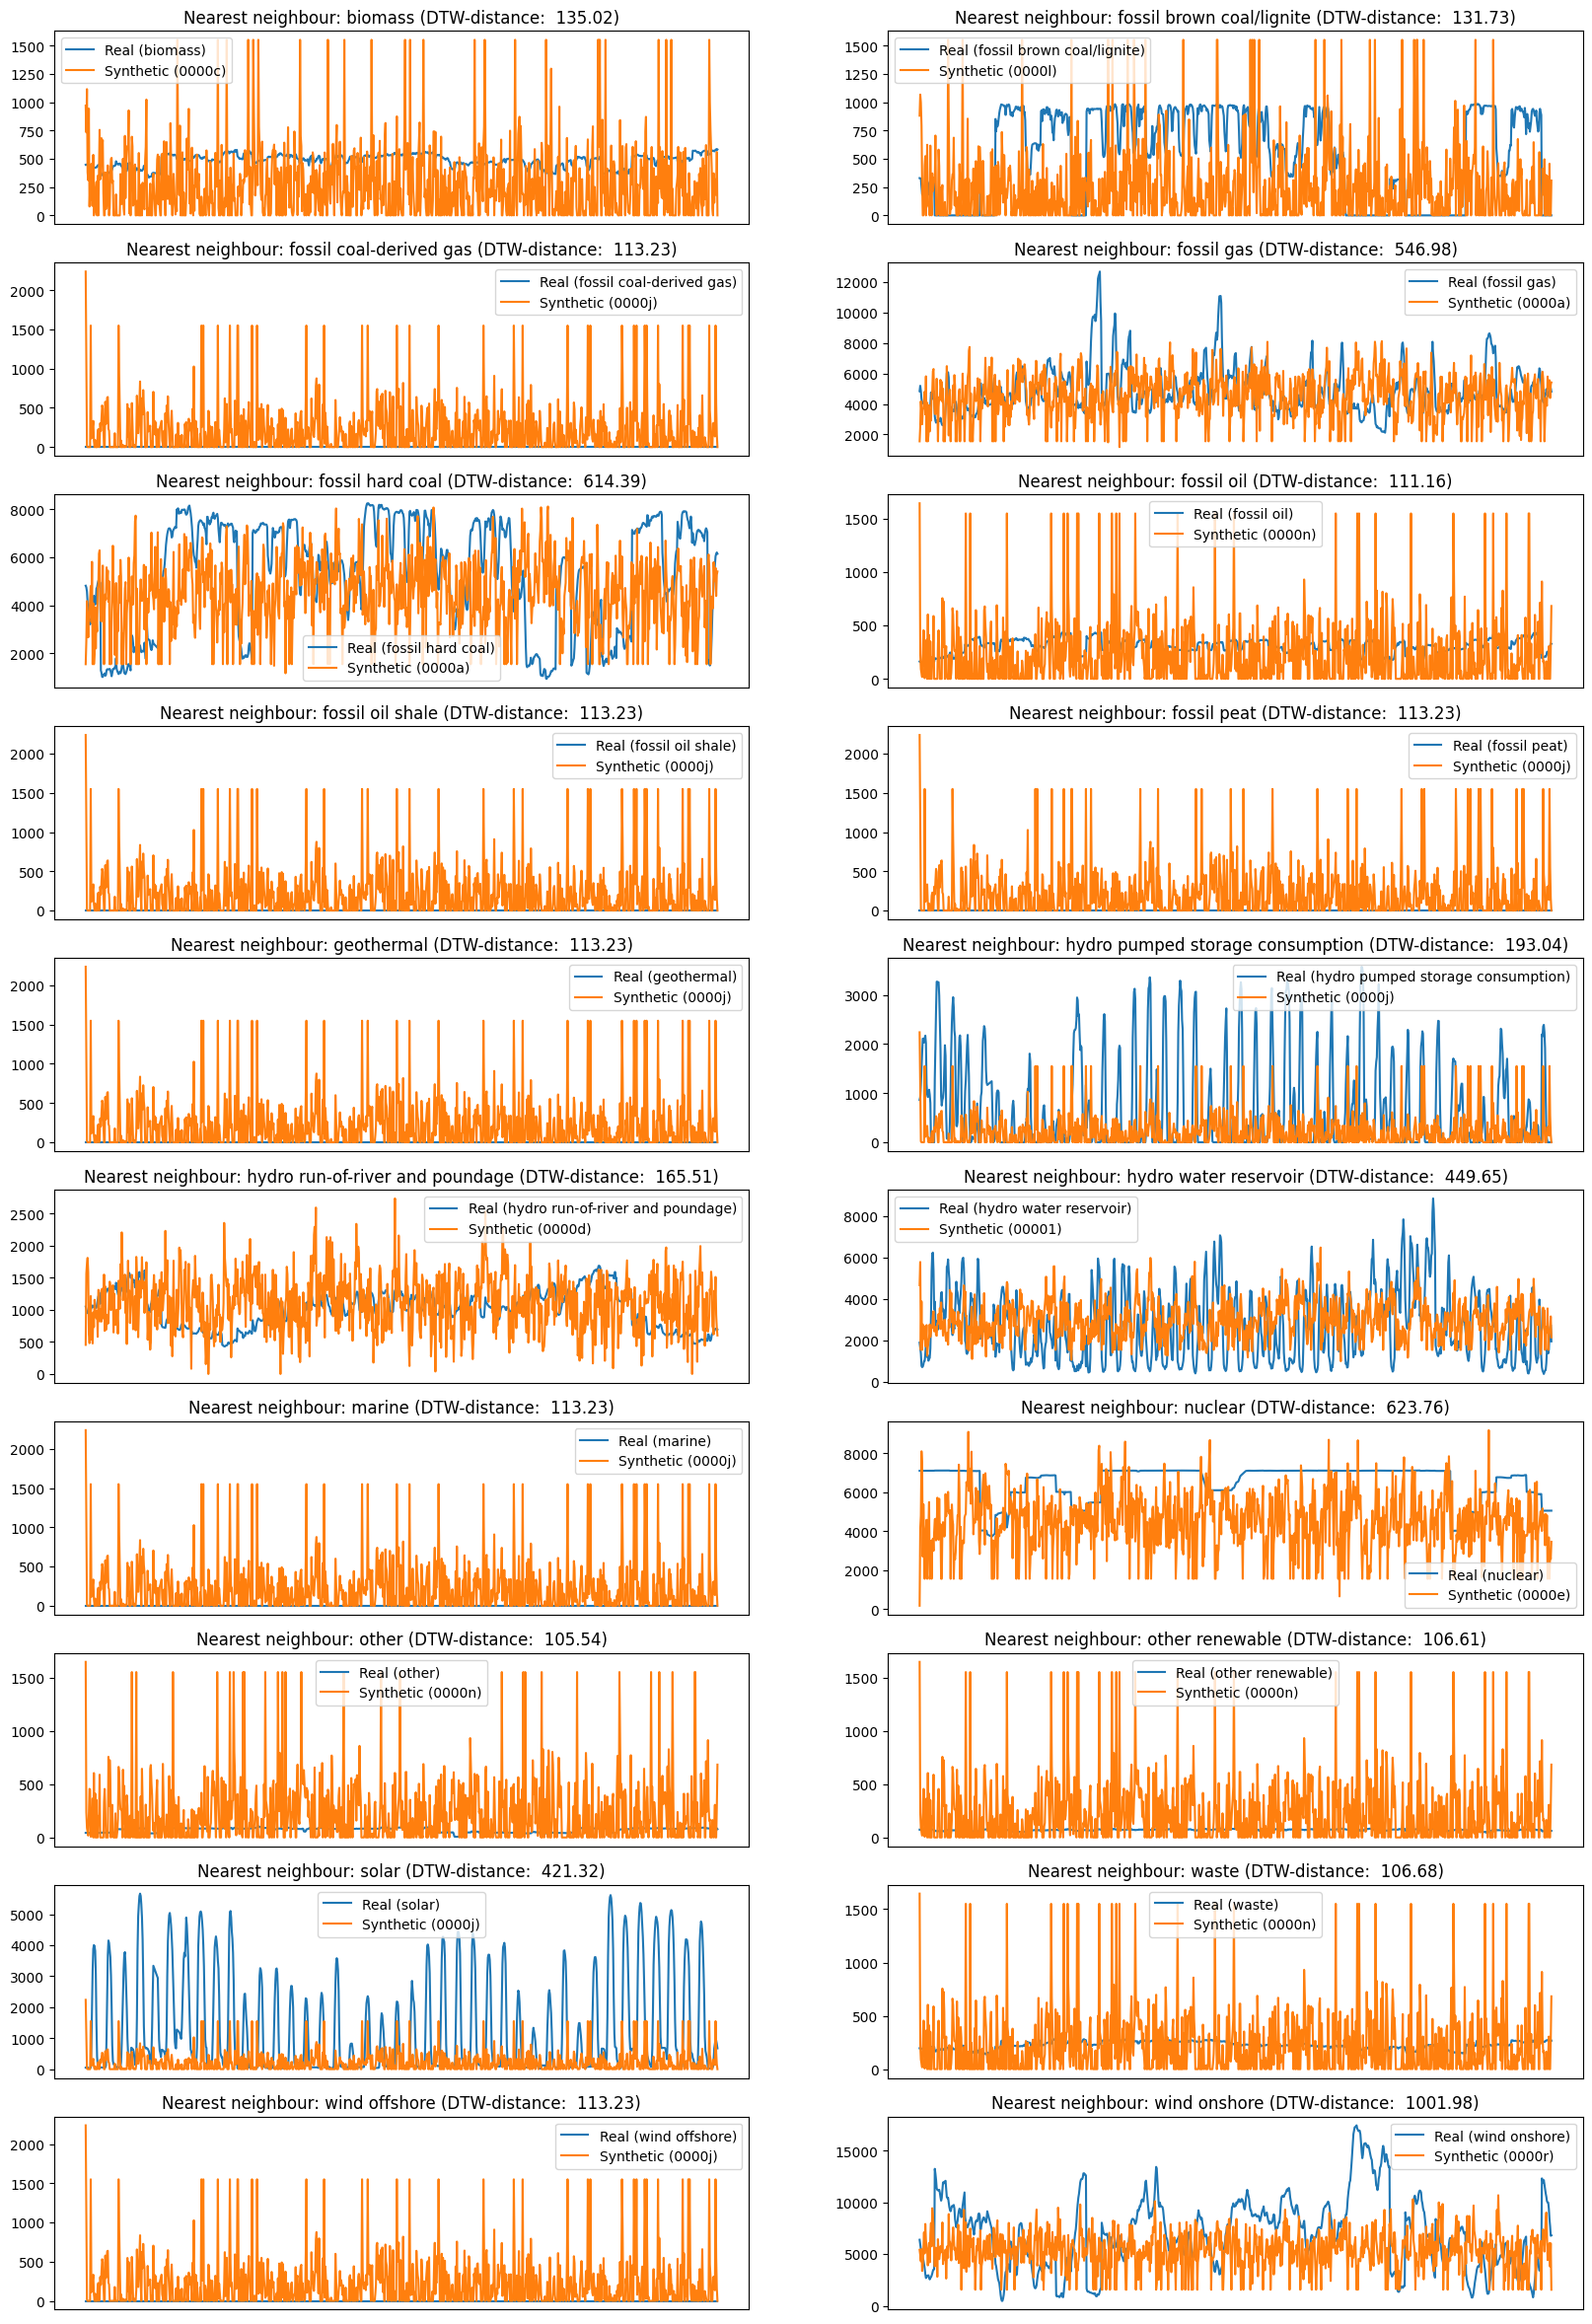

In [163]:
plot_nearest_neighbors(dist_matrix, df_long, synth_data)

In [39]:
# 1000 epochs and 50 generated samples

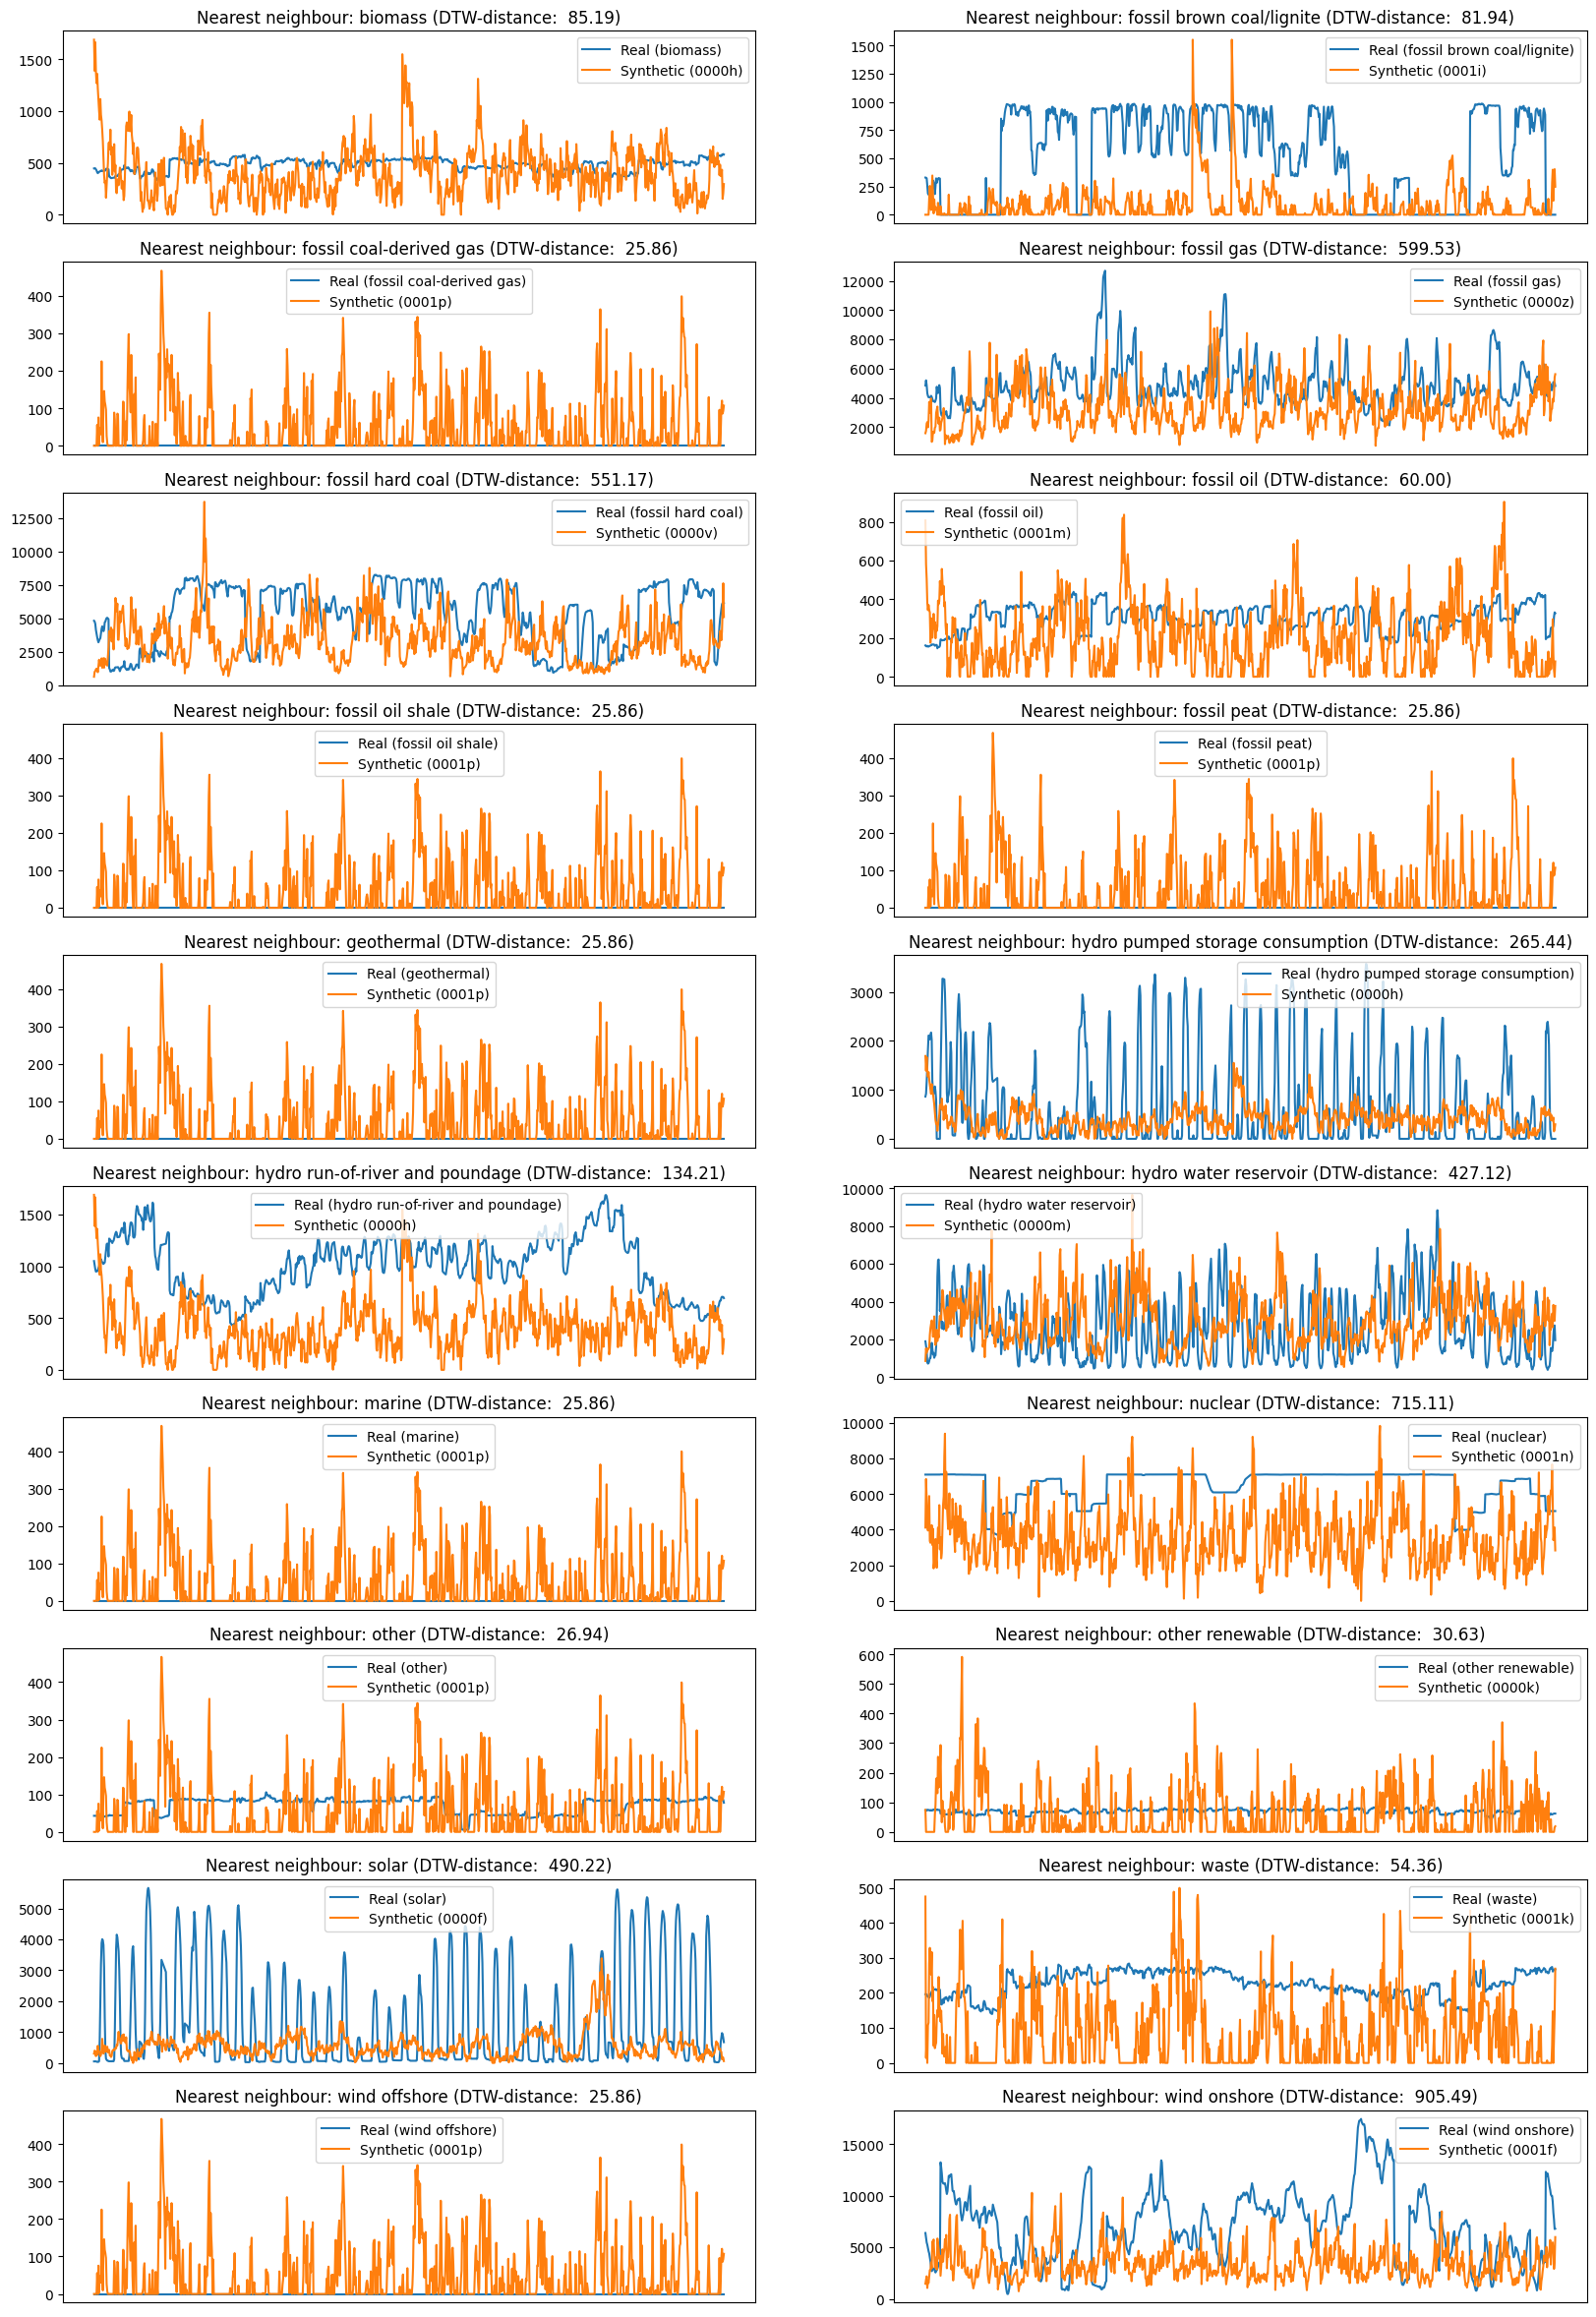

In [38]:
plot_nearest_neighbors(dist_matrix, df_long, synth_data)

### 'Constant' time series

Let's train the model on a subset of time series with very little changes

   * The results here are not overly convincing. It seems as if the general trend is followed, and the mean is correctly captured in most cases, but the synthetic time series remain very noisy even when the original series is constant. This can probably be seen as a drawback of the model. 

In [186]:
constant_ts = df_long[(df_long.energy_source == 'waste') |
                      #(df_long.energy_source == 'other renewable') |
                      #(df_long.energy_source == 'other') |
                      (df_long.energy_source == 'nuclear') |
                      (df_long.energy_source == 'biomass')]

In [187]:
constant_ts

time energy_source  value     mean
0     2014-12-31 23:00:00       biomass  447.0  482.377
1     2015-01-01 00:00:00       biomass  449.0  482.377
2     2015-01-01 01:00:00       biomass  448.0  482.377
3     2015-01-01 02:00:00       biomass  438.0  482.377
4     2015-01-01 03:00:00       biomass  428.0  482.377
...                   ...           ...    ...      ...
17995 2015-02-11 10:00:00         waste  261.0  225.154
17996 2015-02-11 11:00:00         waste  263.0  225.154
17997 2015-02-11 12:00:00         waste  267.0  225.154
17998 2015-02-11 13:00:00         waste  266.0  225.154
17999 2015-02-11 14:00:00         waste  267.0  225.154

[3000 rows x 4 columns]

In [188]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 300, cuda = False, context_columns=['mean'])

# Step 2: Train the synthesizer
synthesizer.fit(constant_ts)

2023-05-24 17:01:18,308 : MainThread : INFO : Fitting table None metadata
2023-05-24 17:01:18,312 : MainThread : INFO : Fitting formatters for table None
2023-05-24 17:01:18,315 : MainThread : INFO : Fitting constraints for table None
2023-05-24 17:01:18,316 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-24 17:01:18,333 : MainThread : INFO : Fitting table None metadata
2023-05-24 17:01:18,335 : MainThread : INFO : Fitting formatters for table None
2023-05-24 17:01:18,336 : MainThread : INFO : Fitting constraints for table None
2023-05-24 17:01:18,337 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-24 17:01:18,350 : MainThread : INFO : Fitting table None metadata
2023-05-24 17:01:18,351 : MainThread : INFO : Fitting formatters for table None
2023-05-24 17:01:18,352 : MainThread : INFO : Fitting constraints for table None
2023-05-24 17:01:18,352 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [189]:
# Sample from it
synth_data = synthesizer.sample(12)

100%|██████████| 12/12 [02:40<00:00, 13.34s/it]


In [190]:
dist_matrix = compute_dtw_matrix(constant_ts, synth_data, metadata)

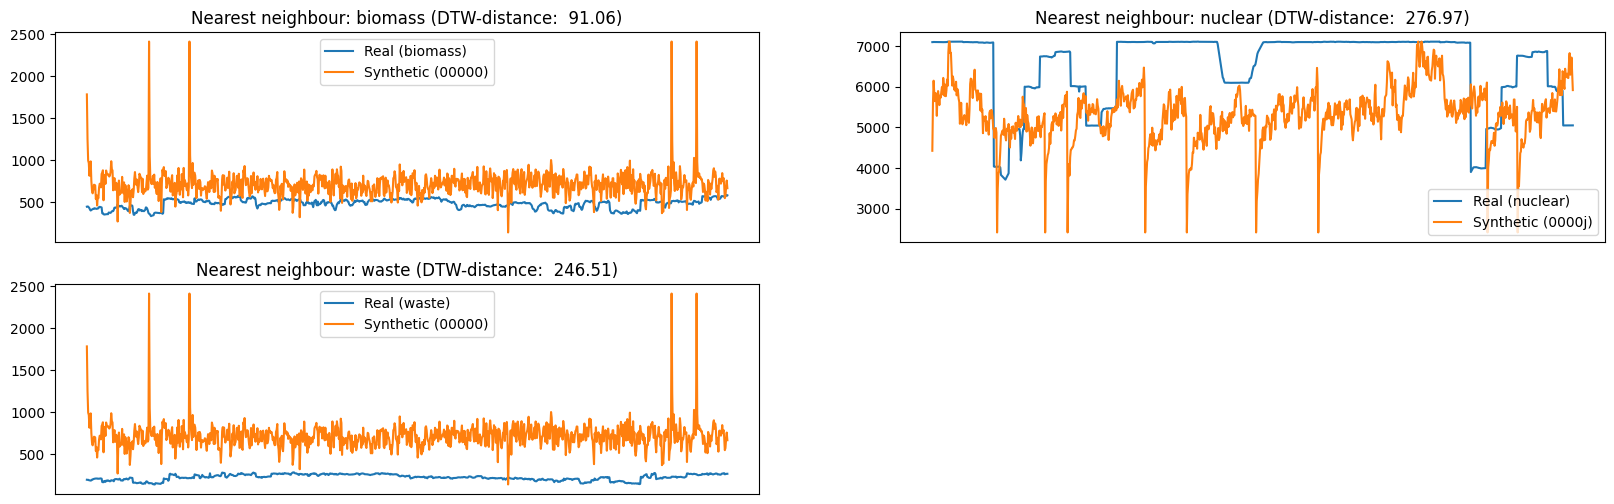

In [191]:
plot_nearest_neighbors(dist_matrix, constant_ts, synth_data)

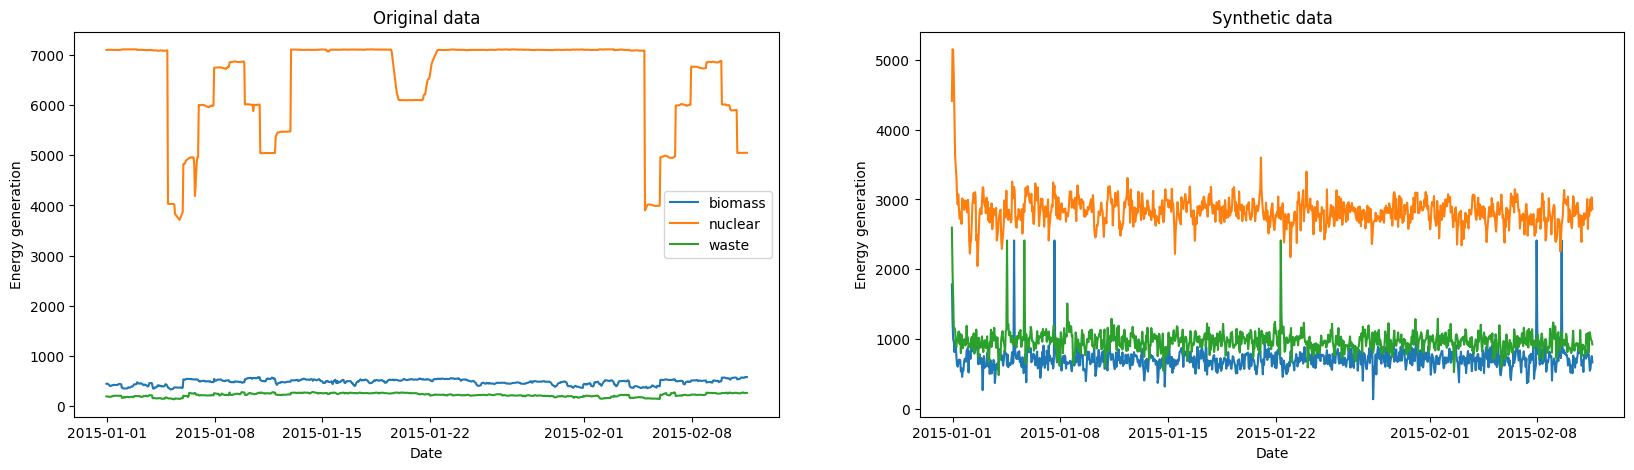

In [192]:
plot_original_synthetic_ts(constant_ts, synth_data, 3, 3)

### Periodic time series

   * Though much less smooth, the periodic time series seem to have been replicated rather well. The time series seem to have similar orders of magnitude and changes.

In [172]:
periodic_ts = df_long[(df_long.energy_source == 'solar') |
                      (df_long.energy_source == 'hydro water reservoir') 
                      ]

In [173]:
# Step 1: Create the synthesizer
synthesizer = PARSynthesizer(metadata, verbose = True, epochs = 300, cuda = False, context_columns=['mean'])

# Step 2: Train the synthesizer
synthesizer.fit(periodic_ts)

2023-05-24 16:51:48,967 : MainThread : INFO : Fitting table None metadata
2023-05-24 16:51:48,968 : MainThread : INFO : Fitting formatters for table None
2023-05-24 16:51:48,970 : MainThread : INFO : Fitting constraints for table None
2023-05-24 16:51:48,971 : MainThread : INFO : Setting the configuration for the ``HyperTransformer`` for table None
2023-05-24 16:51:48,979 : MainThread : INFO : Fitting table None metadata
2023-05-24 16:51:48,980 : MainThread : INFO : Fitting formatters for table None
2023-05-24 16:51:48,981 : MainThread : INFO : Fitting constraints for table None
2023-05-24 16:51:48,982 : MainThread : INFO : Fitting HyperTransformer for table None
2023-05-24 16:51:48,989 : MainThread : INFO : Fitting table None metadata
2023-05-24 16:51:48,990 : MainThread : INFO : Fitting formatters for table None
2023-05-24 16:51:48,990 : MainThread : INFO : Fitting constraints for table None
2023-05-24 16:51:48,990 : MainThread : INFO : Setting the configuration for the ``HyperTransf

In [174]:
synth_data = synthesizer.sample(8)

100%|██████████| 8/8 [01:39<00:00, 12.45s/it]


In [175]:
dist_matrix = compute_dtw_matrix(periodic_ts, synth_data, metadata)

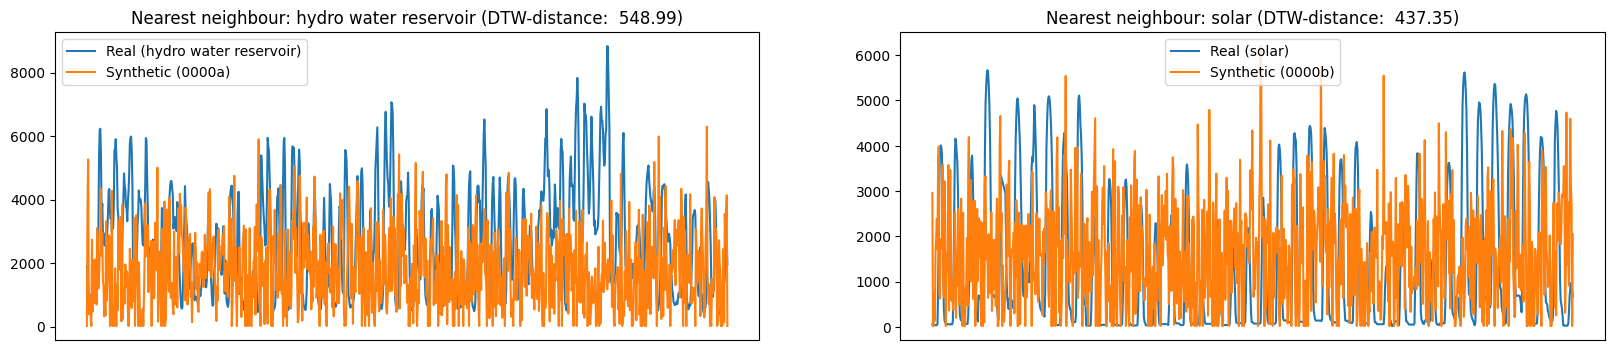

In [176]:
plot_nearest_neighbors(dist_matrix, periodic_ts, synth_data)

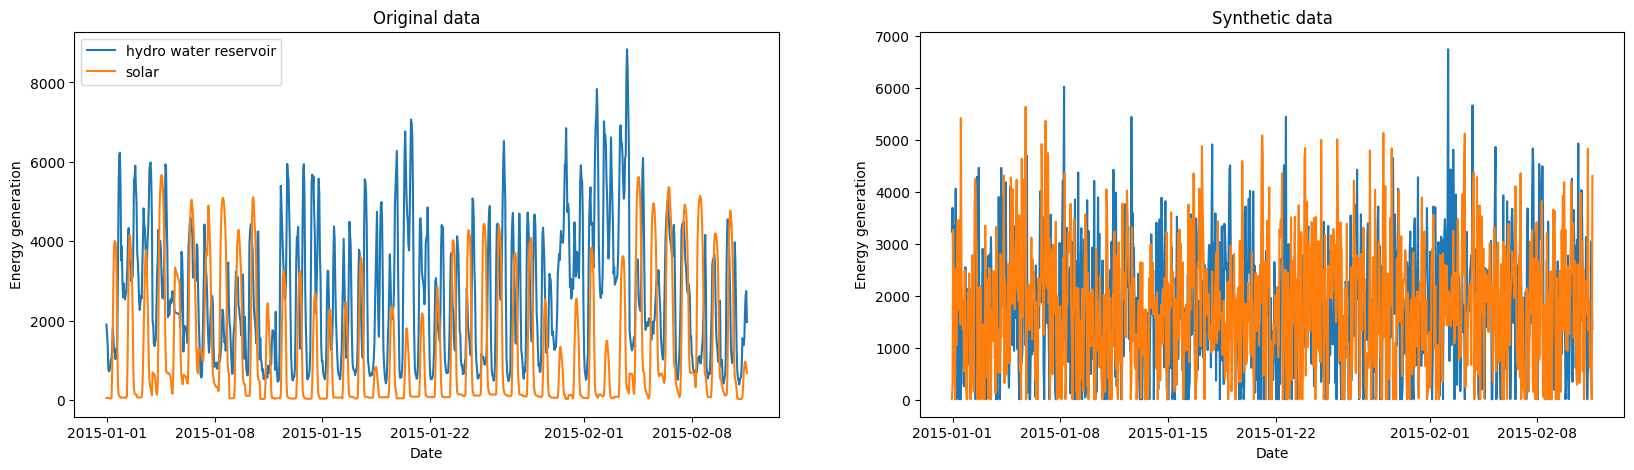

In [177]:
plot_original_synthetic_ts(periodic_ts, synth_data, 2, 2)